# Toy model to test how smoothing kernel transforms shot noise

In [1]:
import numpy as np
import math
import scipy.stats
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from pypower import CatalogMesh

### Create cubic box with uniformly distributed random points and apply Gaussian kernel

In [2]:
seed = 0
offset = -50
boxsize = 100
size = 100000

In [3]:
def gaussian_kernel(positions, sigma):
    r = np.sum(positions**2, axis=0)**0.5
    kernel = np.exp(-r**2/(2. * sigma**2)) / np.sqrt(2*np.pi)
    return kernel

def top_hat_kernel(positions, size):
    r = np.sum(positions**2, axis=0)**0.5
    kernel = np.array([r<size])
    return kernel

def run_exp(param, seed=0):
    # Fill cubic box with random points
    rng = np.random.RandomState(seed=seed)
    positions = np.array([o + rng.uniform(0., 1., size)*b for o, b in zip((offset,)*3, (boxsize,)*3)]) 
    # Apply Gaussian kernel
    kernel = top_hat_kernel(positions, param)
    counts = np.sum(kernel)
    return counts

### Run the experiment N times

In [4]:
N = 1000
result = list()
sigma = 5

for i in range(N):
    counts = run_exp(param=sigma, seed=i)
    result.append(counts)

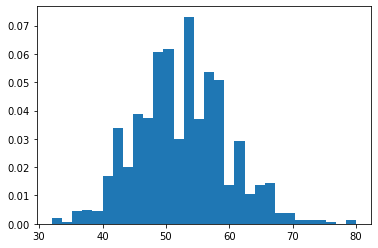

In [5]:
plt.hist(result, bins=30, density=True)
plt.show()

In [6]:
nbar = size / boxsize**3 * (4./3. * np.pi * (sigma)**3)
nbar

52.35987755982989

### Compare with theoretical model

In [7]:
def cumulant(nbar, sigma, p):
    res = 2 * nbar / (p**(3/2) * (1 * np.pi)**((p-3)/2.) * sigma**(p-3))
    return res

def he3(x):
    return x**3 - 3 * x

def he4(x):
    return x**4 - 6 * x**2 + 3

def pdf_from_cumulants(x, cumulants):
    mu, sigma, k3, k4 = cumulants
    y = (x - mu) / sigma
    return np.exp(- y**2/2.) * (1 + k3/(6*sigma**3) * he3(y) + k4/(24*sigma**4) * he4(y)) / (np.sqrt(2*np.pi) * sigma)

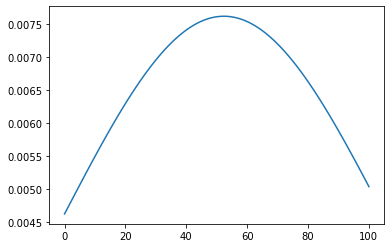

In [8]:
#cumulants = [cumulant(nbar, sigma, i+1) for i in range(4)]
cumulants = [nbar, nbar, nbar, nbar]

x = np.linspace(0, 100, 100)
plt.plot(x, pdf_from_cumulants(x, cumulants))

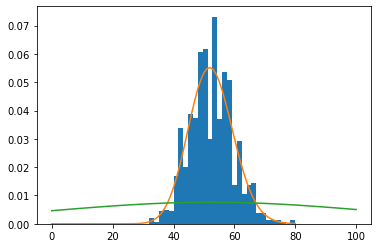

In [23]:
x_int = np.arange(0, 81)
f = scipy.interpolate.interp1d(x_int, scipy.stats.poisson.pmf(x_int, nbar))

plt.hist(result, bins=30, density=True)
plt.plot(x_int, scipy.stats.poisson.pmf(x_int, nbar))
plt.plot(x, pdf_from_cumulants(x, cumulants))
plt.show()